In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
from FeatureDetection import *
from sklearn.model_selection import train_test_split
from pathlib import Path
from sklearn.externals import joblib
import os
import glob
from Helper import Helper
import time
%matplotlib inline


Color Space: I tried different color spaces. RGB gave the worst results with machine learning algorithm. I got good results with YUV color channel so I contined with it. Also I got around %98 accuracy on test data with 1 channel. However, I used all channels to get %99.5 accuracy.

Orient: I use 9 orient blocks. Many research papers uses this value and get good results.

Cell Per Block: I used 2x2 for normalization purposes.

Histogram Bins: I divided my histogram into 32 bins and it gave me better results compared to 16.

In [2]:
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL"#2 # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [500, None] # Min and max in y to search in slide_window()

In [3]:
def create_features(name, visual=True):
    img = read_image(name)
    return create_features_from_image(img, visual=visual)

def create_features_from_image(img, visual=True):
    return FeatureExtractor.extract_features(img, color_space=color_space,
                            spatial_size=spatial_size, hist_bins=hist_bins,
                            orient=orient, pix_per_cell=pix_per_cell,
                            cell_per_block=cell_per_block,
                            hog_channel=hog_channel, spatial_feat=spatial_feat,
                            hist_feat=hist_feat, hog_feat=hog_feat)

In [4]:
def read_image(name):
#     print("Image Name: ", name)
    img = cv2.imread(name)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [5]:
def save(svm, x_train, y_train, x_test, y_test):
    dict = {"SVM":svm, "X_train":x_train, "y_train":y_train, "X_test":x_test, "y_test":y_test}
    joblib.dump(dict, './model.pkl')

In [6]:
def load():
    dict = None
    if Path("./model.pkl").is_file():
        dict = joblib.load('./model.pkl')
        return dict["SVM"], dict[X_train], dict[y_train], dict[X_test], dict[y_test]
    return None

In [7]:
vehicles = glob.glob('./train_images/vehicles/**/*.png', recursive=True)
non_vehicles = glob.glob('./train_images/non-vehicles/**/*.png', recursive=True)
print(str(len(vehicles)) + " vehicle images found.")
print(str(len(non_vehicles)) + " non vehicle images found.")

8792 vehicle images found.
8968 non vehicle images found.


In [8]:
vehicle_features = []
non_vehicle_features = []

t1 = time.time()
for vehicle in vehicles:
    features = create_features(vehicle)
    vehicle_features.append(features)

for non_vehicle in non_vehicles:
    features = create_features(non_vehicle)
    non_vehicle_features.append(features)


feature_len = np.shape(vehicle_features)[-1]
vehicle_features = np.reshape(vehicle_features, (len(vehicles), feature_len))
non_vehicle_features = np.reshape(non_vehicle_features, (len(non_vehicles), feature_len))
    
print("Took " + str(round(time.time()-t1, 2)) + "seconds to create feature vector for training data..") 
print("Vehicle Features Shape: ", np.shape(vehicle_features))
print("Non-Vehicle Features Shape: ", np.shape(non_vehicle_features))
print("Vehicle and non-vehicle feature vectors are created.")

Took 67.6seconds to create feature vector for training data..
Vehicle Features Shape:  (8792, 8460)
Non-Vehicle Features Shape:  (8968, 8460)
Vehicle and non-vehicle feature vectors are created.


In [9]:
# Combines both var and non-car to X array and normalize it
X = np.vstack((vehicle_features, non_vehicle_features)).astype(np.float64)
print(np.shape(X))
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)
y = np.hstack((np.ones(len(vehicle_features)), np.zeros(len(non_vehicle_features))))
print("Fetures are normalized..")

(17760, 8460)
Fetures are normalized..


In [10]:
# Divides data into 2 halves. Train and test
X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2)

In [11]:
print('Using:',orient,'orientations',pix_per_cell,
        'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
print('Spatial Features: ' + str(spatial_feat))
print('Histogram Features: ' + str(hist_feat))
print('Hog Features: ' + str(hog_feat))

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
Spatial Features: True
Histogram Features: True
Hog Features: True


In [12]:
svc = LinearSVC()
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

21.86 Seconds to train SVC...
Test Accuracy of SVC =  0.9938


Vehicle Path:  ./train_images/vehicles/KITTI_extracted/4505.png
Non-Vehicle Path:  ./train_images/non-vehicles/Extras/extra1504.png
Hog Features for Car and Non-Car Images


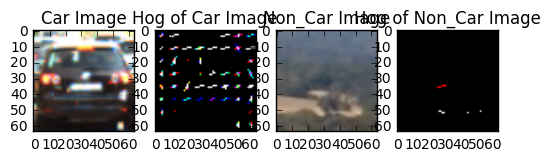

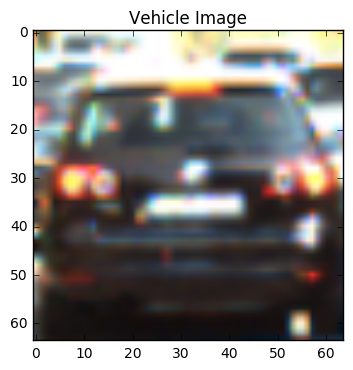

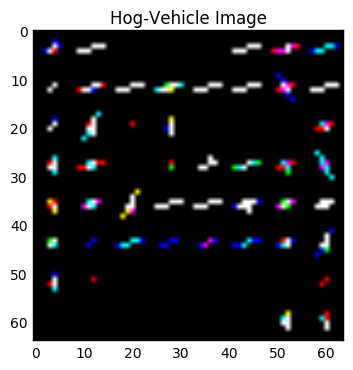

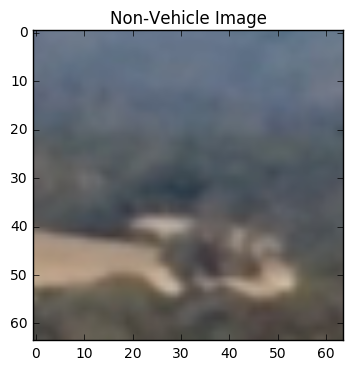

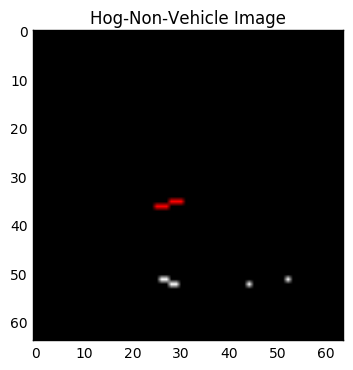

In [52]:
titles = ["Car Image", "Hog of Car Image", "Non_Car Image", "Hog of Non_Car Image"]
vehicle_path = vehicles[np.random.randint(len(vehicles))]
non_vehicle_path = non_vehicles[np.random.randint(len(non_vehicles))]
print("Vehicle Path: ", vehicle_path)
print("Non-Vehicle Path: ", non_vehicle_path)
print("Hog Features for Car and Non-Car Images")

vehicle_img = read_image(vehicle_path)
non_vehicle_img = read_image(non_vehicle_path)
features_car, hog_img1 = FeatureExtractor.get_hog_features(vehicle_img, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, vis=True, hog_channel=hog_channel)
features_non_car, hog_img2 = FeatureExtractor.get_hog_features(non_vehicle_img, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, vis=True, hog_channel=hog_channel)
imgs = [ vehicle_img, hog_img1*255, non_vehicle_img, hog_img2*255]



Helper.plot_images(plt.figure(), 1, 4, imgs, titles)

plt.figure()
plt.title("Vehicle Image")
plt.imshow(vehicle_img)


plt.figure()
plt.title("Hog-Vehicle Image")
plt.imshow(hog_img1*255)


plt.figure()
plt.title("Non-Vehicle Image")
plt.imshow(non_vehicle_img)


plt.figure()
plt.title("Hog-Non-Vehicle Image")
plt.imshow(hog_img2*255)


plt.show()

Test Images


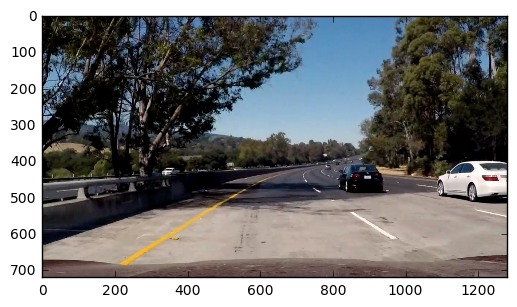

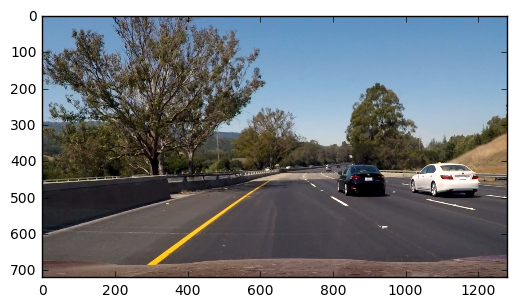

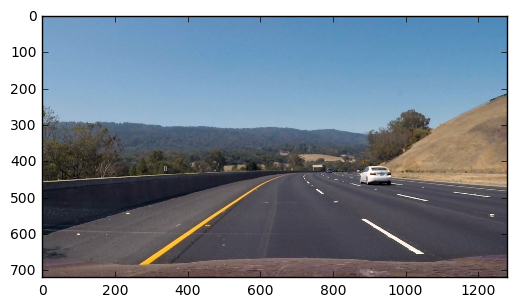

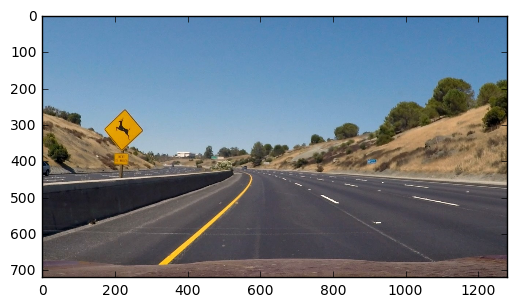

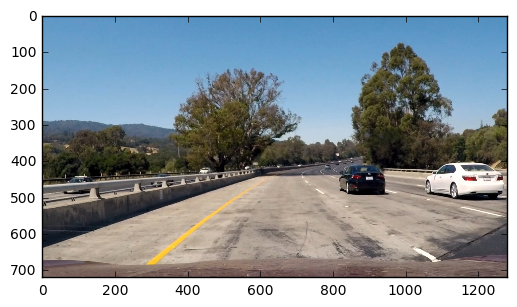

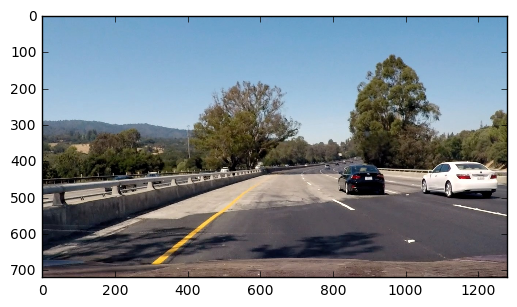

In [14]:
print("Test Images")
test_images = []
imgs = []
files = glob.glob('./test_images/*.jpg', recursive=True)
for image_name in files:
    img = read_image(image_name)
    imgs.append(img)
    test_images.append(img)
    plt.figure()
    plt.imshow(img)
plt.show()

In [15]:
print("Sliding Window: 64x64 windows with 0.5*64 stride")
# windows_list = FeatureExtractor.slide_window(test_image)
# stride_img = Helper.draw_rectangle(test_image, windows_list)
# plt.imshow(stride_img)
# plt.show()

Sliding Window: 64x64 windows with 0.5*64 stride


For each test photos, I applied resize operation to be able to find different size of cars in the image. I found rounding boxes and create a big array of rounding boxes. False positives/negatives may occur. However, for test images I didnt encounter any.

Images with False Detection..
1.24sec per image
1.28sec per image
1.4sec per image
1.32sec per image
1.33sec per image
1.23sec per image


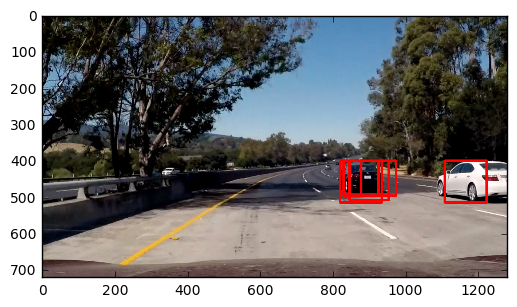

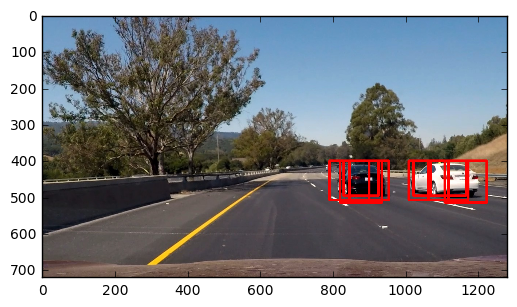

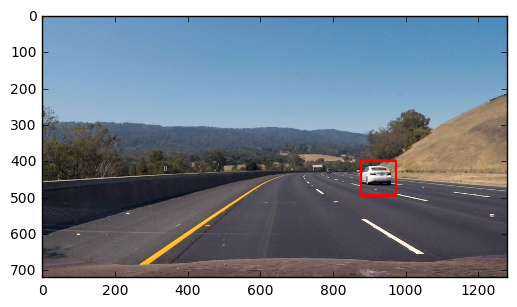

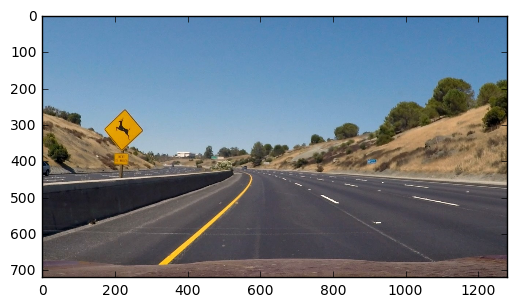

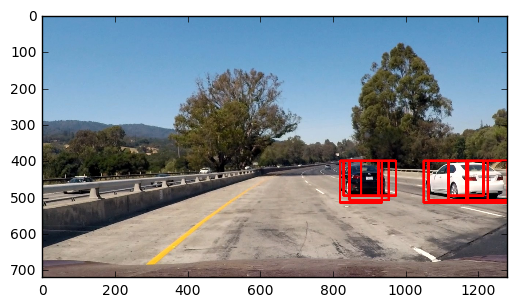

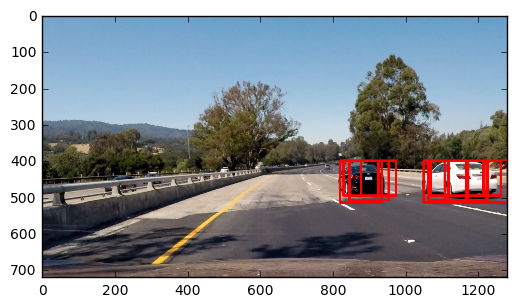

In [16]:
import imutils
def scale_windows(windows, scale, x_start=300, y_start=400):
    res_wins = []
#     scale=1.0
    for win in windows:
        res_wins.append(((x_start+int(win[0][0]*scale), y_start+int(win[0][1]*scale)), (x_start+int(win[1][0]*scale), y_start+int(win[1][1]*scale))))
#         res_wins.append(((int((x_start+win[0][0])/scale), int((y_start+win[0][1])/scale)),  (int((x_start+win[1][0])/scale), int((y_start+win[1][1])/scale))) )
    return res_wins


def find_windows(img, scale, xy_window=(96,96)):
    y,x, c = np.shape(img)
    x_start = int(300/scale)#int(x*(1.0/6))
    y_start = int(400/scale)
    tmp = img.copy()[y_start:, x_start:,:]
    windowss = FeatureExtractor.slide_window(tmp, x_start_stop=[None, None],y_start_stop=[None,None],xy_window=xy_window, xy_overlap=(0.5, 0.5))
    tmp = FeatureExtractor.search_windows(tmp, windowss, svc, X_scaler, color_space=color_space,
                        spatial_size=spatial_size, hist_bins=hist_bins,
                        hist_range=(0, 256), orient=9,
                        pix_per_cell=8, cell_per_block=2,
                        hog_channel="ALL", spatial_feat=True,
                        hist_feat=True, hog_feat=True)
    
    return scale_windows(tmp, scale, 300,400)


print("Images with False Detection..")

for img in imgs:
    win = []
    t1 = time.time()
    for scale in [1.5,1.7,1.8]:
        w = int(img.shape[1] / scale)
        resized = imutils.resize(img, width=w)
        win0 = find_windows(resized, scale, xy_window=(64,64))
        win += win0

    rec_img = Helper.draw_rectangle(img, win)
    print(str(round(time.time()-t1,2))+"sec per image")
    plt.figure()
    plt.imshow(rec_img)
plt.show()

For each test image, I found the rounding boxes and based on those boxes, I created a heatmap image. Both images and corresponding heatmaps can be seen below.

Also, I used labeling methods and thresholded rectangles. Based on the result, I get 1 rectangle per car.

Heat Map Images


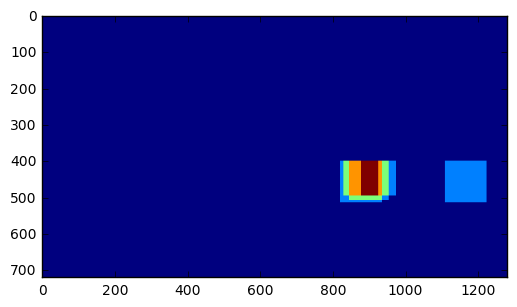

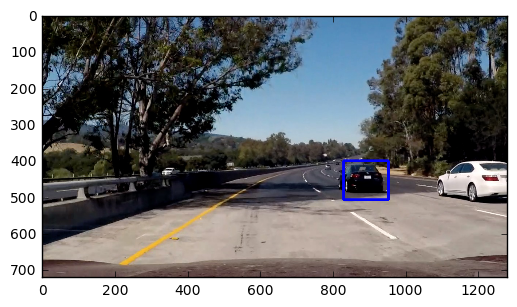

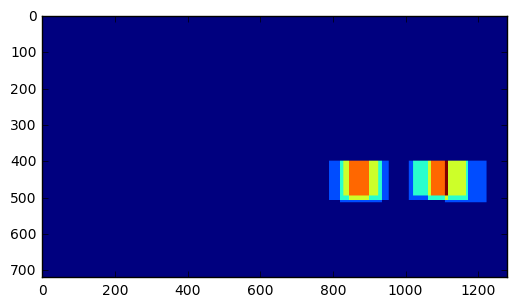

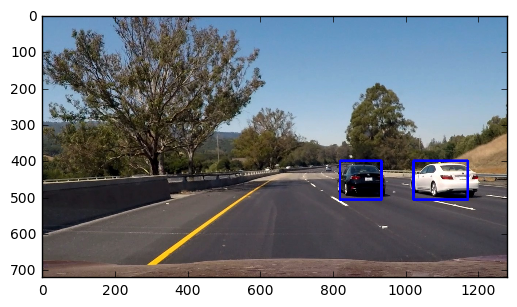

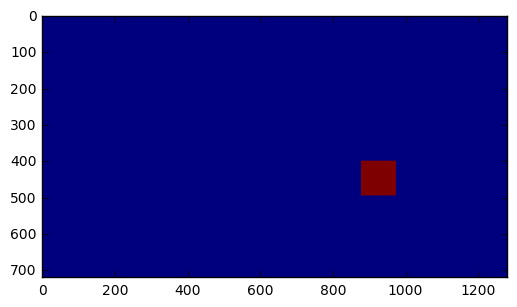

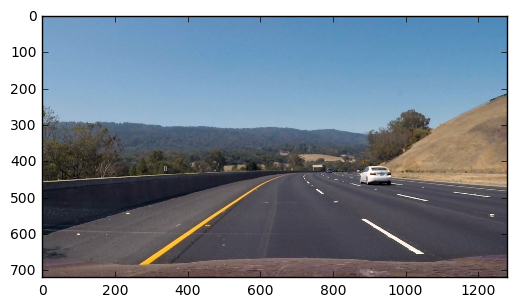

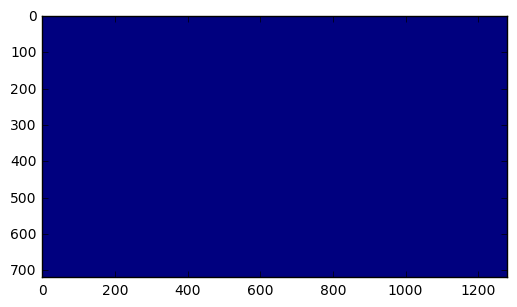

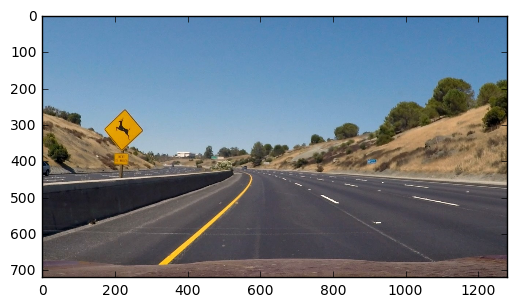

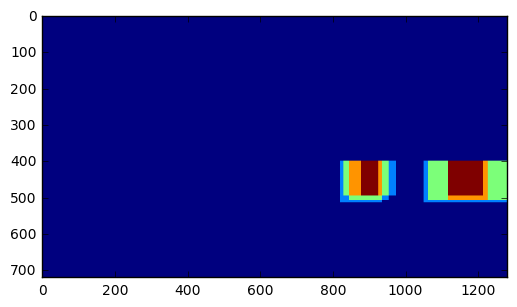

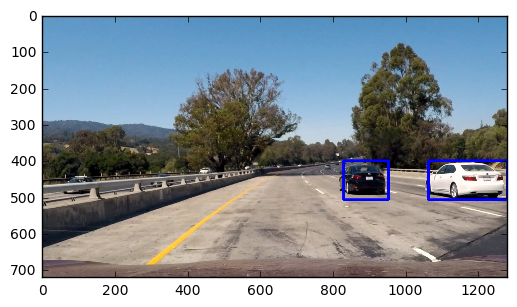

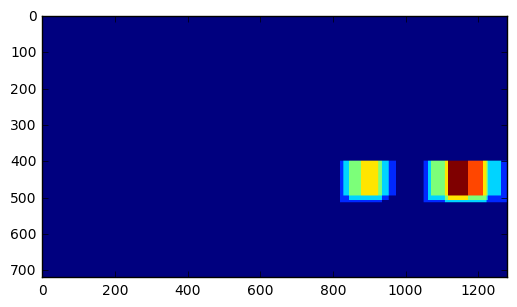

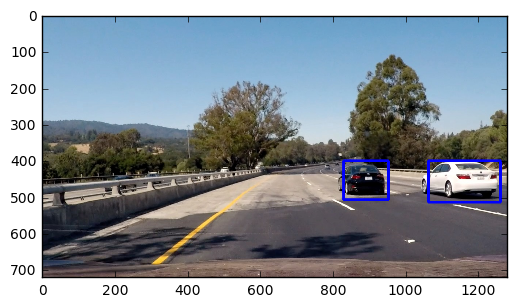

In [40]:
def pipeline(img, show_heatmap=False, false_negative=True):
    win = []
    t1 = time.time()
    for scale in [1.5,1.7,1.8]:
        w = int(img.shape[1] / scale)
        resized = imutils.resize(img, width=w)
        win0 = find_windows(resized, scale, xy_window=(64,64))
        win += win0
    # We found all possible windows with False Negatives
    # Now lets create heat map and remove false positives
    
    heat_map = FeatureExtractor.add_heat(img, win)
    if show_heatmap==True:
        plt.figure()
        plt.imshow(heat_map)
        plt.show()
    
    if false_negative==True:
        heat_map = FeatureExtractor.apply_threshold(heat_map, threshold=1)
    
    labels = label(heat_map)
    return FeatureExtractor.draw_labeled_bboxes(img, labels)
        
        
        
print("Heat Map Images")
for img in imgs:
    plt.figure()
    plt.imshow(pipeline(img, show_heatmap=True, false_negative=True))
plt.show()

Applied the same pipeline on test video.

In [21]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'test_video_output.mp4'
clip1 = VideoFileClip("test_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 97%|█████████▋| 38/39 [00:31<00:00,  1.19it/s]      | 1/39 [00:00<00:34,  1.12it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

CPU times: user 47 s, sys: 112 ms, total: 47.1 s
Wall time: 32.5 s


In [22]:

%%HTML
<video width="640" height="480" controls>
  <source src="test_video_output.mp4" type="video/mp4">
</video>

Applied the pipeline on project video.

In [23]:
white_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [18:27<00:00,  1.11it/s]    | 1/1261 [00:00<18:31,  1.13it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 27min 38s, sys: 2.61 s, total: 27min 40s
Wall time: 18min 28s


In [24]:
%%HTML
<video width="640" height="480" controls>
  <source src="project_video_output.mp4" type="video/mp4">
</video>

Created a new averages pipeline. This method, tooks last 25 images' heatmaps and apply logical or on them. Result, heatmap is an average heatmap. Later I used this heatmap to find smoother rectangle for cars.

In [41]:
heatmaps = []

def concatenate_heatmaps(heatmaps):
    hmap = heatmaps[0]
    for heatmap in heatmaps:
        hmap = np.logical_or(hmap, heatmap)
        
    return 1*hmap
        


def average_pipeline(img):
    win = []
    t1 = time.time()
    for scale in [1.5,1.7,1.8]:
        w = int(img.shape[1] / scale)
        resized = imutils.resize(img, width=w)
        win0 = find_windows(resized, scale, xy_window=(64,64))
        win += win0
    # We found all possible windows with False Negatives
    # Now lets create heat map and remove false positives
    
    heat_map = FeatureExtractor.add_heat(img, win)
    heat_map = FeatureExtractor.apply_threshold(heat_map, threshold=1)
    
    heatmaps.append(heat_map)
    if len(heatmaps) > 25:
        heatmaps.pop(0)
        
    heat_map = concatenate_heatmaps(heatmaps)
    
    labels = label(heat_map)
    return FeatureExtractor.draw_labeled_bboxes(img, labels)





Applied average pipeline to test video.

In [42]:
white_output = 'test_video_output_ave.mp4'
clip1 = VideoFileClip("test_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)


[MoviePy] >>>> Building video test_video_output_ave.mp4
[MoviePy] Writing video test_video_output_ave.mp4


 97%|█████████▋| 38/39 [00:32<00:00,  1.19it/s]      | 1/39 [00:01<00:38,  1.02s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output_ave.mp4 

CPU times: user 48.9 s, sys: 80 ms, total: 49 s
Wall time: 33.4 s


In [43]:
%%HTML
<video width="640" height="480" controls>
  <source src="test_video_output_ave.mp4" type="video/mp4">
</video>

Applied average pipeline to project video.

In [55]:
white_output = 'project_video_output_ave.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(average_pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_output_ave.mp4
[MoviePy] Writing video project_video_output_ave.mp4



100%|█████████▉| 1260/1261 [19:17<00:00,  1.10it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output_ave.mp4 

CPU times: user 28min 43s, sys: 2.82 s, total: 28min 46s
Wall time: 19min 17s


In [56]:
%%HTML
<video width="640" height="480" controls>
  <source src="project_video_output_ave.mp4" type="video/mp4">
</video>

As a final note, it can be seen from the results averaging increased the false positives on the projct image. However, it rectangles look better and less shaky.